## Image Captioning

#### Used Resnet pretrained model to extract image features
#### Flickr 8K dataset for Model Building.This dataset has 8092 images with 5 captions for each image. I have used only 1000 images to train the model due to memory issue

In [2]:
import pandas as pd
import numpy as np
import cv2,os
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input,Dense,Embedding,LSTM,Dropout
from keras.layers.merge import add
from tensorflow.keras.utils import plot_model
from keras.models import Model

In [3]:
image_path="/content/Images/"
images=glob(image_path+ "*.jpg")

In [4]:
len(images)

8091

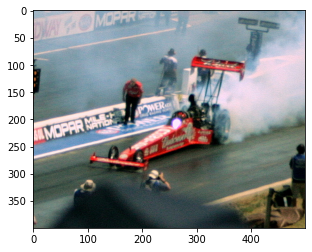

In [ ]:
img=cv2.imread(images[1])
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

#### Image Processing

In [5]:
#importing resnet model
image_model=ResNet50(include_top=True)

In [ ]:
image_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [6]:
output=image_model.layers[-2].output  # excluding the last layer of the model
new_model=Model(inputs=image_model.input,outputs=output)
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [7]:
#Giving all the images to the model and extracting features.
image_features={}
count=0
for i in images:
  img=cv2.imread(i)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img=cv2.resize(img,(224,224))
  img=img.reshape(1,224,224,3)
  predictions=new_model.predict(img).reshape(2048,)

  img_name=i.split("/")[-1]
  image_features[img_name]=predictions
  count += 1

  if count > 999:       #Due to memory issue used only 1000 images 
    break
len(image_features)

1000

In [8]:
image_features

{'3683592946_262e9bfbfd.jpg': array([1.1925277 , 0.1890683 , 0.26390582, ..., 0.00874291, 0.0541475 ,
        0.05452518], dtype=float32),
 '1358089136_976e3d2e30.jpg': array([1.3275894 , 0.25641888, 0.7367274 , ..., 0.6199038 , 0.        ,
        0.        ], dtype=float32),
 '3227423095_5049951eab.jpg': array([0.03528919, 1.3567156 , 0.68399614, ..., 0.10846757, 0.        ,
        0.9482971 ], dtype=float32),
 '3247693965_845b3b4349.jpg': array([1.3806766 , 1.0900452 , 0.526208  , ..., 0.24861163, 0.34660274,
        0.47519392], dtype=float32),
 '1206506157_c7956accd5.jpg': array([1.4456664 , 1.8188055 , 0.17784907, ..., 0.05116546, 0.        ,
        0.9853542 ], dtype=float32),
 '127450902_533ceeddfc.jpg': array([1.5855523 , 0.11971283, 0.15978363, ..., 0.        , 0.00620989,
        0.        ], dtype=float32),
 '3070713991_8696796937.jpg': array([0.38866046, 0.9235087 , 0.07934689, ..., 0.06731238, 0.0459487 ,
        0.19260481], dtype=float32),
 '2831723637_30d4456665.jpg'

#### Caption Processing

In [9]:
caption_path="/content/captions.txt"
caption=open(caption_path,'rb').read().decode('utf-8').split('\n')
caption

['image,caption',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow wi

In [10]:
caption_dict={}
for i in caption:
  try:
    img_name=i.split(',')[0]
    captio=i.split(',')[1]
    if img_name in image_features:
      if img_name not in caption_dict:
        caption_dict[img_name]=[captio]
      else:
        caption_dict[img_name].append(captio)


  except:
    pass

# keeping only one unique image name with 5 captions as a list 

In [11]:
len(caption_dict)

1000

In [12]:
caption_dict

{'1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a girl with pigtails sitting in front of a rainbow painting .',
  'Young girl with pigtails painting outside in the grass .'],
 '1019077836_6fc9b15408.jpg': ['A brown dog chases the water from a sprinkler on a lawn .',
  'a brown dog plays with the hose .',
  'A brown dog running on a lawn near a garden hose',
  'A dog is playing with a hose .',
  'Large brown dog running away from the sprinkler in the grass .'],
 '1022454428_b6b660a67b.jpg': ['"A couple and an infant ',
  'A couple sit on the grass with a baby and stroller .',
  'A couple with their newborn baby sitting under a tree facing a lake .',
  'A man and woman care for an infant along the side of a body of water .',
  '

In [13]:
# Adding start and end tokens to each caption
for keys ,values in caption_dict.items():
  for i in values:
    caption_dict[keys][values.index(i)]='startofseq ' +i.lower()+' endofseq'

In [14]:
caption_dict

{'1002674143_1b742ab4b8.jpg': ['startofseq a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . endofseq',
  'startofseq a little girl is sitting in front of a large painted rainbow . endofseq',
  'startofseq a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it . endofseq',
  'startofseq there is a girl with pigtails sitting in front of a rainbow painting . endofseq',
  'startofseq young girl with pigtails painting outside in the grass . endofseq'],
 '1019077836_6fc9b15408.jpg': ['startofseq a brown dog chases the water from a sprinkler on a lawn . endofseq',
  'startofseq a brown dog plays with the hose . endofseq',
  'startofseq a brown dog running on a lawn near a garden hose endofseq',
  'startofseq a dog is playing with a hose . endofseq',
  'startofseq large brown dog running away from the sprinkler in the grass . endofseq'],
 '1022454428_b6b660a67b.jpg': ['startofseq "a couple and an infant  end

In [15]:
# Creating a vocabulary
count=1
count_words={}
for keys,values in caption_dict.items():
  for i in values:
    for word in i.split():
      if word not in count_words:
        count_words[word]=count
        count+=1

In [16]:
count_words

{'startofseq': 1,
 'a': 2,
 'little': 3,
 'girl': 4,
 'covered': 5,
 'in': 6,
 'paint': 7,
 'sits': 8,
 'front': 9,
 'of': 10,
 'painted': 11,
 'rainbow': 12,
 'with': 13,
 'her': 14,
 'hands': 15,
 'bowl': 16,
 '.': 17,
 'endofseq': 18,
 'is': 19,
 'sitting': 20,
 'large': 21,
 'small': 22,
 'the': 23,
 'grass': 24,
 'plays': 25,
 'fingerpaints': 26,
 'white': 27,
 'canvas': 28,
 'on': 29,
 'it': 30,
 'there': 31,
 'pigtails': 32,
 'painting': 33,
 'young': 34,
 'outside': 35,
 'brown': 36,
 'dog': 37,
 'chases': 38,
 'water': 39,
 'from': 40,
 'sprinkler': 41,
 'lawn': 42,
 'hose': 43,
 'running': 44,
 'near': 45,
 'garden': 46,
 'playing': 47,
 'away': 48,
 '"a': 49,
 'couple': 50,
 'and': 51,
 'an': 52,
 'infant': 53,
 'sit': 54,
 'baby': 55,
 'stroller': 56,
 'their': 57,
 'newborn': 58,
 'under': 59,
 'tree': 60,
 'facing': 61,
 'lake': 62,
 'man': 63,
 'woman': 64,
 'care': 65,
 'for': 66,
 'along': 67,
 'side': 68,
 'body': 69,
 'outdoors': 70,
 'next': 71,
 'to': 72,
 'uses': 

In [17]:
# Converting words to numbers for our model
for keys,values in caption_dict.items():
  for i in values:
    encoded=[]
    for word in i.split():
      encoded.append(count_words[word])

    caption_dict[keys][values.index(i)] =encoded

In [18]:
caption_dict

{'1002674143_1b742ab4b8.jpg': [[1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   6,
   9,
   10,
   2,
   11,
   12,
   13,
   14,
   15,
   6,
   2,
   16,
   17,
   18],
  [1, 2, 3, 4, 19, 20, 6, 9, 10, 2, 21, 11, 12, 17, 18],
  [1,
   2,
   22,
   4,
   6,
   23,
   24,
   25,
   13,
   26,
   6,
   9,
   10,
   2,
   27,
   28,
   13,
   2,
   12,
   29,
   30,
   17,
   18],
  [1, 31, 19, 2, 4, 13, 32, 20, 6, 9, 10, 2, 12, 33, 17, 18],
  [1, 34, 4, 13, 32, 33, 35, 6, 23, 24, 17, 18]],
 '1019077836_6fc9b15408.jpg': [[1,
   2,
   36,
   37,
   38,
   23,
   39,
   40,
   2,
   41,
   29,
   2,
   42,
   17,
   18],
  [1, 2, 36, 37, 25, 13, 23, 43, 17, 18],
  [1, 2, 36, 37, 44, 29, 2, 42, 45, 2, 46, 43, 18],
  [1, 2, 37, 19, 47, 13, 2, 43, 17, 18],
  [1, 21, 36, 37, 44, 48, 40, 23, 41, 6, 23, 24, 17, 18]],
 '1022454428_b6b660a67b.jpg': [[1, 49, 50, 51, 52, 53, 18],
  [1, 2, 50, 54, 29, 23, 24, 13, 2, 55, 51, 56, 17, 18],
  [1, 2, 50, 13, 57, 58, 55, 20, 59, 2, 60, 61, 2, 62, 17, 18],


In [19]:
# Checking the maximum length of a caption in the given dataset
max_len=0
for keys,values in caption_dict.items():
  for i in values:
    if len(i)>max_len:
      max_len=len(i)

print(max_len)

34


In [21]:
Vocab=len(count_words)
Vocab=Vocab+1
Vocab

3234

#### Generating 3 lists which will be given to the model later

In [23]:
def generate(images , caption_dict):
  x_image=[]
  y_in=[]
  y_out=[]

  for keys,values in caption_dict.items():
    for i in values:
      for j in range(1,len(i)):
        x_image.append(images[keys])
        seq_in=[i[:j]]
        seq_out=i[j]

        seq_in=pad_sequences(seq_in,maxlen=max_len,padding='post',truncating='post')[0]
        seq_out=to_categorical([seq_out],num_classes=Vocab)[0]

        y_in.append(seq_in)
        y_out.append(seq_out)

  return x_image,y_in,y_out



In [24]:
x_image,y_in,y_out=generate(image_features,caption_dict)

In [25]:
len(x_image),len(y_in),len(y_out)

(61073, 61073, 61073)

In [26]:
#Converting lists to array
x_image=np.array(x_image)
y_in=np.array(y_in , dtype='float64')
y_out=np.array(y_out, dtype='float64')

In [28]:
x_image.shape,y_in.shape,y_out.shape

((61073, 2048), (61073, 34), (61073, 3234))

#### Model Building (CNN and LSTM)

In [30]:
input1=Input(shape=(2048,))
feature=Dropout(0.2)(input1) # to avoid overfitting
feature1=Dense(128, activation='relu')(feature)

input2=Input(shape=(max_len,))
seq=Embedding(Vocab , 128,mask_zero=True)(input2)
seq1=Dropout(0.2)(seq)
seq2=LSTM(128)(seq1)

decoder1=add([feature1,seq2])
decoder2=Dense(128,activation='relu')(decoder1)
output=Dense(Vocab,activation='softmax')(decoder2)

model=Model(inputs=[input1,input2],outputs=output)
model.compile(loss='categorical_crossentropy' , optimizer='adam')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 128)      413952      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

#### Model Architecture

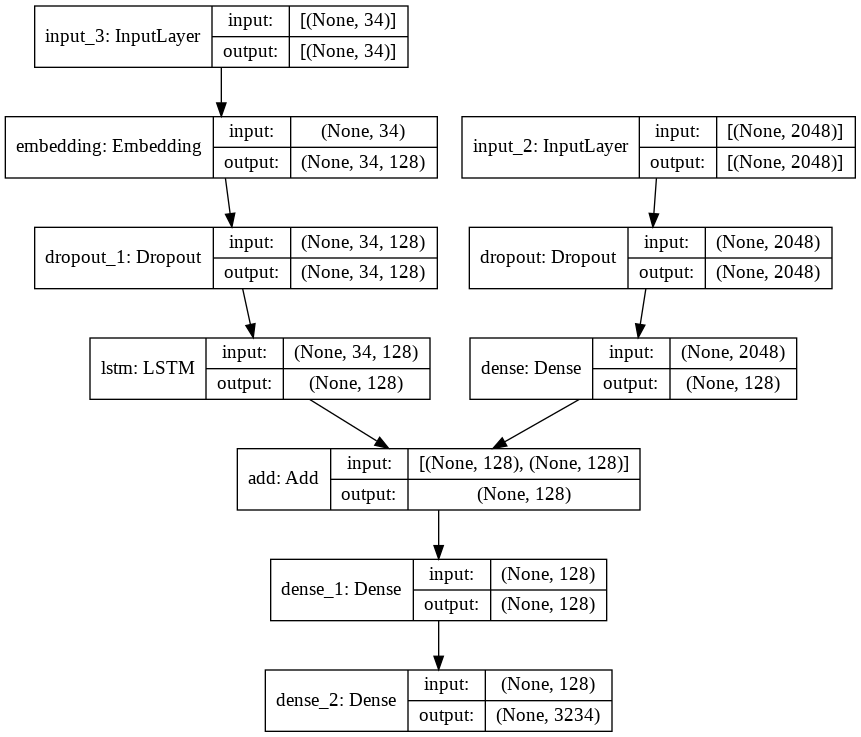

In [31]:
plot_model(model,to_file='model.png',show_shapes=True)

In [32]:
model.fit([x_image,y_in],y_out , batch_size=256,epochs=50)

Epoch 1/50
239/239 [==============================] - 12s 26ms/step - loss: 4.9335
Epoch 2/50
239/239 [==============================] - 6s 26ms/step - loss: 3.8225
Epoch 3/50
239/239 [==============================] - 6s 25ms/step - loss: 3.3128
Epoch 4/50
239/239 [==============================] - 6s 26ms/step - loss: 2.9636
Epoch 5/50
239/239 [==============================] - 6s 25ms/step - loss: 2.6922
Epoch 6/50
239/239 [==============================] - 6s 25ms/step - loss: 2.4780
Epoch 7/50
239/239 [==============================] - 6s 25ms/step - loss: 2.3053
Epoch 8/50
239/239 [==============================] - 6s 26ms/step - loss: 2.1713
Epoch 9/50
239/239 [==============================] - 6s 25ms/step - loss: 2.0587
Epoch 10/50
239/239 [==============================] - 6s 25ms/step - loss: 1.9655
Epoch 11/50
239/239 [==============================] - 6s 25ms/step - loss: 1.8826
Epoch 12/50
239/239 [==============================] - 6s 26ms/step - loss: 1.8078
Epoch 13/50


In [33]:
model.save('image_caption.h5')
model.save_weights('image_caption_weights.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#### Model Prediction using an image

In [34]:
images[4000]

'/content/Images/1433142189_cda8652603.jpg'

In [35]:
img=cv2.imread(images[4000])
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(224,224))
img=img.reshape(1,224,224,3)
predictions=new_model.predict(img).reshape(1,2048)

In [36]:
predictions

array([[2.230565  , 0.9132932 , 0.27074334, ..., 0.85624737, 0.        ,
        0.14266397]], dtype=float32)

In [37]:
# Inverse dictionary to map the numbers with predicted index and give words as an Output
text_input=['startofseq']
inverse_dict={v:k for k,v in count_words.items()}

In [38]:
inverse_dict

{1: 'startofseq',
 2: 'a',
 3: 'little',
 4: 'girl',
 5: 'covered',
 6: 'in',
 7: 'paint',
 8: 'sits',
 9: 'front',
 10: 'of',
 11: 'painted',
 12: 'rainbow',
 13: 'with',
 14: 'her',
 15: 'hands',
 16: 'bowl',
 17: '.',
 18: 'endofseq',
 19: 'is',
 20: 'sitting',
 21: 'large',
 22: 'small',
 23: 'the',
 24: 'grass',
 25: 'plays',
 26: 'fingerpaints',
 27: 'white',
 28: 'canvas',
 29: 'on',
 30: 'it',
 31: 'there',
 32: 'pigtails',
 33: 'painting',
 34: 'young',
 35: 'outside',
 36: 'brown',
 37: 'dog',
 38: 'chases',
 39: 'water',
 40: 'from',
 41: 'sprinkler',
 42: 'lawn',
 43: 'hose',
 44: 'running',
 45: 'near',
 46: 'garden',
 47: 'playing',
 48: 'away',
 49: '"a',
 50: 'couple',
 51: 'and',
 52: 'an',
 53: 'infant',
 54: 'sit',
 55: 'baby',
 56: 'stroller',
 57: 'their',
 58: 'newborn',
 59: 'under',
 60: 'tree',
 61: 'facing',
 62: 'lake',
 63: 'man',
 64: 'woman',
 65: 'care',
 66: 'for',
 67: 'along',
 68: 'side',
 69: 'body',
 70: 'outdoors',
 71: 'next',
 72: 'to',
 73: 'use

In [41]:
count=0
while count <25:
  count+=1
  encoded=[]
  for i in text_input:
    encoded.append(count_words[i])

  encoded=[encoded]
  encoded=pad_sequences(encoded,maxlen=max_len,padding='post',truncating='post')
  pred=np.argmax(model.predict([predictions,encoded]))
  sample=inverse_dict[pred]

  if sample =='endofseq':
    break
  text_input.append(sample)


In [42]:
text_input

['startofseq',
 'a',
 'man',
 'is',
 'posing',
 'on',
 'a',
 'hill',
 'of',
 'snow',
 '.']

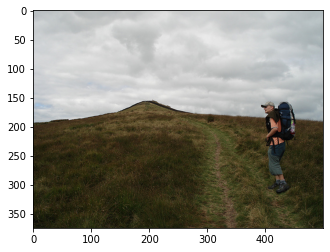

In [45]:
i=cv2.imread(images[4000])
i=cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
plt.imshow(i)